In [1]:
import anndata
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import statsmodels.api as sm
import os
import statsmodels.stats.multitest
from adjustText import adjust_text

In [2]:
os.chdir('/home/coakes/rat/')
from rat_friend import *
os.chdir('/home/coakes/virus_rat/')

# Load Adata

## Load Virus Data

In [3]:
virus_adata = anndata.read_h5ad("/home/coakes/virus_rat/virus_post_qc.h5ad")
virus_adata.obs.time = virus_adata.obs.time.astype('int')
virus_adata = virus_adata[~virus_adata.obs['time'].isna()]
virus_adata = virus_adata[:,~virus_adata.var.contaminate]
virus_adata.obs['lifetime'] = [8 if x == 0 else x for x in virus_adata.obs.time.values]
virus_adata

/tmp/ipykernel_2034342/3429301357.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  virus_adata.obs['lifetime'] = [8 if x == 0 else x for x in virus_adata.obs.time.values]


AnnData object with n_obs × n_vars = 861 × 30758
    obs: 'barcode', 'index', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'old_tissue', 'lifetime'
    var: 'rep_ID', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'contaminate', 'known', 'n_counts'

In [4]:
# Maximize number of tissues and rats with the most overlap
test_df = virus_adata.obs[['nid', 'tissue']]
test_df2 = test_df.groupby('nid').agg({'tissue': set}).reset_index()
test_df2['tiss_count'] = test_df.groupby('nid').count().reset_index(drop=True)
test_df2 = test_df2[test_df2.tiss_count > 16]
tiss_list = set.intersection(*test_df2.tissue.to_list())
print(tiss_list)
nid_list = test_df2.nid.to_list()

# get set of tissues and rats with most overlap
virus_adata = virus_adata[virus_adata.obs.tissue.isin(tiss_list)]
virus_adata = virus_adata[virus_adata.obs.nid.isin(nid_list)]
virus_adata

{'BLOOD', 'KIDNEY', 'WAT', 'ADRNL', 'SKM-VL', 'HEART', 'LUNG', 'SMLINT', 'HYPOTH', 'HIPPOC', 'SKM-GN', 'SPLEEN', 'CORTEX'}


/tmp/ipykernel_2034342/714092077.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_df2 = test_df.groupby('nid').agg({'tissue': set}).reset_index()
/tmp/ipykernel_2034342/714092077.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_df2['tiss_count'] = test_df.groupby('nid').count().reset_index(drop=True)


View of AnnData object with n_obs × n_vars = 507 × 30758
    obs: 'barcode', 'index', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'old_tissue', 'lifetime'
    var: 'rep_ID', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'contaminate', 'known', 'n_counts'

Sum virus by individual

In [5]:
nid_virus_adata = sum_by(virus_adata, 'nid')
nid_virus_adata.obs = pd.merge(nid_virus_adata.obs.reset_index(names='nid'), virus_adata.obs.groupby('nid').first()[['sex', 'time', 'lifetime']].reset_index())
nid_virus_adata

/tmp/ipykernel_2034342/3342687752.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nid_virus_adata.obs = pd.merge(nid_virus_adata.obs.reset_index(names='nid'), virus_adata.obs.groupby('nid').first()[['sex', 'time', 'lifetime']].reset_index())


AnnData object with n_obs × n_vars = 39 × 30758
    obs: 'nid', 'sex', 'time', 'lifetime'
    var: 'rep_ID', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'contaminate', 'known', 'n_counts'

## Load Rat Data

In [6]:
rat_adata = anndata.read_h5ad("/home/coakes/rat/omics_adata/rat_RNA_meta.h5ad")
rat_adata.layers['counts'] = rat_adata.X
rat_adata = rat_adata[rat_adata.obs.nid.isin(nid_list)]
rat_adata

View of AnnData object with n_obs × n_vars = 685 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [7]:
nid_rat_adata = sum_by(rat_adata, 'nid')
nid_rat_adata.obs = pd.merge(nid_rat_adata.obs.reset_index(names='nid'), rat_adata.obs.groupby('nid').first()[['sex', 'time']].reset_index())
nid_rat_adata

/tmp/ipykernel_2034342/54662949.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nid_rat_adata.obs = pd.merge(nid_rat_adata.obs.reset_index(names='nid'), rat_adata.obs.groupby('nid').first()[['sex', 'time']].reset_index())


AnnData object with n_obs × n_vars = 39 × 24770
    obs: 'nid', 'sex', 'time'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'

# Find Correlation of Virus Counts over Time

In [8]:
analysis_df = pd.DataFrame({
    'total_virus' : np.sum(nid_virus_adata.X.toarray(), axis=1),
    'total_virus_std' : np.std(nid_virus_adata.X.toarray(), axis=1),
    'time' : nid_virus_adata.obs['time'],
    'lifetime' : nid_virus_adata.obs['lifetime'],
    'sex' : nid_virus_adata.obs['sex'],
    'nid' : nid_virus_adata.obs['nid']
})
print('time')
time_corr = analysis_df['total_virus'].corr(analysis_df['time'])
print(f'Pearson R = {np.round(time_corr, 4)}')
print(f'P-value = {np.round(2*scipy.stats.beta(nid_virus_adata.shape[0]/2 -1, nid_virus_adata.shape[0]/2 -1, loc=-1, scale=2).cdf(-abs(time_corr)), 4)}')

time
Pearson R = 0.242
P-value = 0.1378


In [9]:
print('lifetime')
time_corr = analysis_df['total_virus'].corr(analysis_df['lifetime'])
print(f'Pearson R = {np.round(time_corr, 4)}')
print(f'P-value = {np.round(2*scipy.stats.beta(nid_virus_adata.shape[0]/2 -1, nid_virus_adata.shape[0]/2 -1, loc=-1, scale=2).cdf(-abs(time_corr)), 4)}')

lifetime
Pearson R = 0.4935
P-value = 0.0014


Text(0, 0.5, 'Total Counts of All Virus')

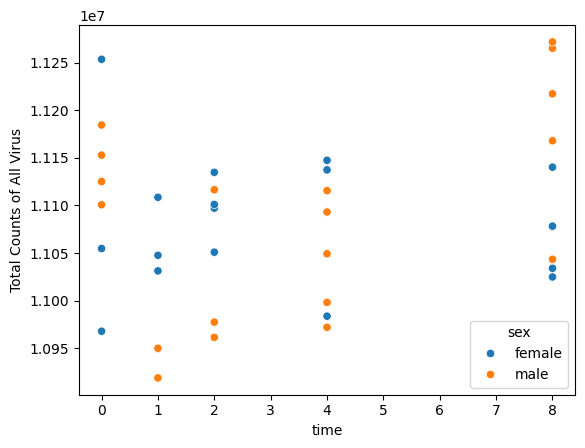

In [10]:
sns.scatterplot(analysis_df, x = 'time', y = 'total_virus', hue = 'sex')
plt.ylabel('Total Counts of All Virus')

# Plot Virus Counts Over Lifetime

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in 

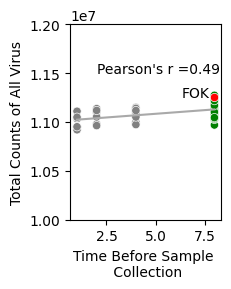

In [11]:
res = scipy.stats.pearsonr(analysis_df['total_virus'].values, analysis_df['lifetime'].values)
plt.figure(figsize=(2.5, 3))
m, b = np.polyfit(analysis_df['lifetime'].values, analysis_df['total_virus'].values, 1)
X_plot = np.linspace(1,8,100)


analysis_df['passon'] = [True if x == 8 else False for x in analysis_df.lifetime]
#analysis_df.loc[analysis_df['nid'] == 'F0K', 'passon'] = 'red'
sns.scatterplot(analysis_df, x = 'lifetime', y = 'total_virus', hue = 'passon',
               palette = {True: 'green', False: 'grey'}
               )
sns.scatterplot(analysis_df[analysis_df['nid'] == 'F0K'], x = 'lifetime', y = 'total_virus', hue = 'passon',
               palette = {True: 'red'}
               )
plt.text(s='FOK', x = analysis_df[analysis_df['nid'] == 'F0K'].lifetime-.25, y = analysis_df[analysis_df['nid'] == 'F0K'].total_virus, 
            ha='right'
               )
plt.text(2, 1.15e7, "Pearson's r ={:.2f}".format(res[0]))
plt.plot(X_plot, m*X_plot + b, '-', color='darkgrey')
plt.ylabel('Total Counts of All Virus')
#plt.yscale('log')
plt.ylim([1e7, 1.2e7])
plt.xlabel('Time Before Sample \n Collection')
plt.legend('', frameon=False)
plt.tight_layout()
plt.savefig('figures_final/fig_3a.png')